# Python Code ICU prediction

1: Load the data


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.impute   import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics  import plot_precision_recall_curve, accuracy_score, auc, roc_curve, precision_recall_curve, f1_score, roc_auc_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold

df = pd.read_excel("Downloads/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")


In [44]:
conda install -c conda-forge shap

^C

CondaError: KeyboardInterrupt


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install shap

### Feature Description and Preprocessing, Dimensionaility Reduction
2: Convert age percentile to ordinal \
3: Remove zero / low variance columns \
4: Remove high multicollinearity columns \
5: Add a minmax scaled column that is sum of missing value row wise.

In [3]:
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB
   PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65 AGE_PERCENTIL  GENDER  \
0                         0            1          60th       0   
1                         0            1          60th       0   
2                         0            1          60th       0   
3                         0            1          60th       0   
4                         0            1          60th       0   

   DISEASE GROUPING 1  DISEASE GROUPING 2  DISEASE GROUPING 3  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   DISEASE GROUPING 

In [2]:
print(df.shape)

(1925, 231)


In [3]:
# 2: Convert age percentile to ordinal
pcts = sorted(df.AGE_PERCENTIL.unique())
age_percentile_encoding = {k: i for i, k in enumerate(pcts)}
df.AGE_PERCENTIL = df.AGE_PERCENTIL.replace(age_percentile_encoding)

In [4]:
print(df['AGE_PERCENTIL'].unique())

[5 8 0 3 6 1 4 7 2 9]


In [42]:
print(df['PCR_MEDIAN'])

0      -0.875236
1      -0.875236
2      -0.875236
3      -0.875236
4      -1.000000
          ...   
1920   -0.906238
1921   -0.906238
1922   -0.906238
1923   -0.906238
1924   -0.801134
Name: PCR_MEDIAN, Length: 1925, dtype: float64


In [6]:
# GROUPING FEATURES
# DEMOGRAPHICS
demo_lst = [i for i in df.columns if "AGE_" in i]
demo_lst.append("GENDER")

# COMORBIDITIES
comorb_lst = [i for i in df.columns if "DISEASE" in i]
comorb_lst.extend(["HTN", "IMMUNOCOMPROMISED", "OTHER"])

# VITAL SIGNS
vitalSigns_lst = df.iloc[:,193:231].columns.tolist()

# LAB VALUES
lab_lst = df.iloc[:,13:193].columns.tolist()

# mean features
lab_median = [xi for xi in lab_lst if xi.endswith('MEDIAN')]
vital_median = [xi for xi in vitalSigns_lst if xi.endswith('MEDIAN')]

#DF WITH ONLY MEDIAN VALUES
df = df[demo_lst + comorb_lst + lab_median + vital_median + ['ICU'] + ['WINDOW'] + ['PATIENT_VISIT_IDENTIFIER']]

print(df.shape)

(1925, 57)


In [7]:
print(lab_lst)
print(vitalSigns_lst)

['ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN', 'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CALCIUM_DIFF', 'CREATININ_MEDIAN', 'CREATININ_MEAN', 'CREATININ_MIN', 'CREATININ_MAX', 'CREATININ_DIFF', 'FFA_MEDIAN', 'FFA_MEAN', 'FFA_MIN', 'FFA_MAX', 'FFA_DIFF', 'GGT_MEDIAN', 'GGT_MEAN', 'GGT_MIN', 'GGT_MAX', 'GGT_DIFF', 'GLUCOSE_MEDIAN', 'GLUCOSE_MEAN', 'GLUCOSE_MIN', 'GLUCOSE_MAX', 'GLUCOSE_D

In [8]:
# 3: Remove zero / low variance columns 
df = df.loc[:, df.nunique() != 1] 
print(df.shape) #36 zero variance columns removed #0 REMOVED FOR MEDIAN ANALYSIS

(1925, 57)


In [9]:
colvar = df.var()
cols_to_remove = colvar[colvar < 0.01].index.tolist()
df = df.drop(columns = cols_to_remove)
print(df.shape) #28 low variance columns removed #7 REMOVED FOR MEDIAN ANALYSIS

(1925, 50)


AxesSubplot(0.125,0.125;0.62x0.755)


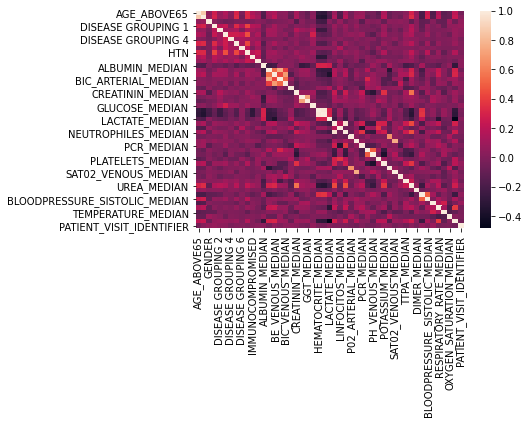

In [10]:
# 4: Remove high multicollinearity columns 
cor = df.corr(method = 'pearson')
print(sns.heatmap(cor))

In [11]:
corr_pairs = cor.unstack().sort_values(ascending = False).drop_duplicates()
high_corr = corr_pairs[abs(corr_pairs) > 0.8]
print(high_corr)

PATIENT_VISIT_IDENTIFIER  PATIENT_VISIT_IDENTIFIER    1.000000
HEMATOCRITE_MEDIAN        HEMOGLOBIN_MEDIAN           0.979391
NEUTROPHILES_MEDIAN       LEUKOCYTES_MEDIAN           0.965082
AGE_ABOVE65               AGE_PERCENTIL               0.868951
dtype: float64


In [12]:
feature1_target = [] #Create a list of feature 1 names
for x in high_corr.index.to_list():
    feature1_target.append(x[0])
print(feature1_target)

feature2_target = [] #Create a list of feature 2 names
for x in high_corr.index.to_list():
    feature2_target.append(x[1])
print(feature2_target)

target_cor = abs(cor["ICU"]) 
feature1_cor_icu = []
feature2_cor_icu = []

for feat in feature1_target:
    feature1_cor_icu.append(target_cor[feat])

for feat in feature2_target:
    feature2_cor_icu.append(target_cor[feat])
    


['PATIENT_VISIT_IDENTIFIER', 'HEMATOCRITE_MEDIAN', 'NEUTROPHILES_MEDIAN', 'AGE_ABOVE65']
['PATIENT_VISIT_IDENTIFIER', 'HEMOGLOBIN_MEDIAN', 'LEUKOCYTES_MEDIAN', 'AGE_PERCENTIL']


In [13]:
def compareList(l1, l2):
    return [i<j for i, j in zip(l1, l2)] #Is feature 1 correlation with target smaller than feature 2 correlation with target?

smaller_feat1 = compareList(feature1_cor_icu, feature2_cor_icu)
remove_smaller_feat1 = [x for x, y in zip(feature1_target, smaller_feat1) if y]
#print(remove_smaller_feat1)

smaller_feat2 = compareList(feature2_cor_icu, feature1_cor_icu)
remove_smaller_feat2 = [x for x, y in zip(feature2_target, smaller_feat2) if y]
#print(remove_smaller_feat2)
cols_multicollinear = remove_smaller_feat1 + remove_smaller_feat2

df = df.drop(columns = cols_multicollinear)

print(df.shape) #20 columns dropped #2 COLUMNS DROPPED FOR MEDIAN ANALYSIS

(1925, 47)


In [14]:
# 5: Add a minmax scaled column that is sum of missing value row wise. 
df['Missingness'] = df.isnull().sum(axis = 1)
scaler = MinMaxScaler()
df[['Missingness']] = scaler.fit_transform(df[['Missingness']])
#print(df.head())

### Missing Data
- Foreward / backward fill
- Multiple Imputation 

6: Fill missing data by neighbouring windows using foreward / backward fill

In [15]:
# 6: Fill missing data by neighbouring windows using foreward / backward fill
df = df\
    .sort_values(by=['PATIENT_VISIT_IDENTIFIER', 'WINDOW'])\
    .groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)\
    .fillna(method='ffill')\
    .fillna(method='bfill')

#print(df.head())

In [16]:
# 7: Fill missing data by Multiple imputation 

### Labeling
8: Labeling
- Make a dataframe of non-icu admitted patients's 0-2 h data : Negative label
- Make dataframe of ICU admitted patients with lagged data: Positive label
- Concatinate dataframes
- Remove ID column 



In [17]:
# 8: Labeling
pd.crosstab(df.WINDOW, df.ICU)


ICU,0,1
WINDOW,,
0-2,353,32
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


In [18]:
#Make a dataframe of non-icu admitted patients's 0-2 h data
no_icu_data = df[(df.ICU == 0) & (df.WINDOW == 'ABOVE_12') ]
no_icu_id = no_icu_data['PATIENT_VISIT_IDENTIFIER'].to_list()
no_icu_df = df[(df.PATIENT_VISIT_IDENTIFIER.isin(no_icu_id) & (df.WINDOW == '0-2'))]
no_icu_df = no_icu_df.drop(columns = 'WINDOW')
print(no_icu_df)

      AGE_PERCENTIL  GENDER  DISEASE GROUPING 1  DISEASE GROUPING 2  \
15                3       1                 0.0                 0.0   
20                0       0                 0.0                 0.0   
25                0       0                 0.0                 0.0   
30                6       1                 0.0                 0.0   
35                1       0                 0.0                 0.0   
...             ...     ...                 ...                 ...   
1885              1       1                 0.0                 0.0   
1890              0       1                 0.0                 0.0   
1905              9       0                 0.0                 0.0   
1915              3       1                 0.0                 0.0   
1920              4       1                 0.0                 0.0   

      DISEASE GROUPING 3  DISEASE GROUPING 4  DISEASE GROUPING 5  \
15                   0.0                 0.0                 0.0   
20         

In [19]:
#Make dataframe of ICU admitted patients with lagged data. 
icu_df = df[np.logical_not(df.PATIENT_VISIT_IDENTIFIER.isin(no_icu_id))]
         
#FIRST DISCARD PATIENTS THAT ARE ICU ADMITTED IN 0-2H 
icu_df_grouped = icu_df.groupby('PATIENT_VISIT_IDENTIFIER')
icu_02_ids = []
for group_name, group in icu_df_grouped:
    group.ICU.to_list()
    if len(group['ICU'].unique()) ==1:
        icu_02_ids.append(group_name)   
print(icu_02_ids) #List of 32 id's of 0-2h admitted ICU

icu_df_no02 = icu_df[np.logical_not(icu_df.PATIENT_VISIT_IDENTIFIER.isin(icu_02_ids))] #Dataframe consisting if patients ICU admitted in either 2-4, 4-6, 6-12 or 12+

[1, 17, 27, 41, 47, 48, 54, 62, 85, 90, 104, 106, 109, 117, 144, 176, 202, 206, 226, 233, 239, 261, 270, 282, 286, 306, 315, 329, 359, 362, 366, 379]


In [20]:
#OF PATIENTS THAT ARE ADMITTED IN 2-4 HOUR TIMEFRAME, SELECT 0-2 H DATA. 
icu_24_ids = []
for group_name, group in icu_df_no02.groupby('PATIENT_VISIT_IDENTIFIER'):
    if group.ICU.to_list() == [0, 1, 1, 1, 1]:
        icu_24_ids.append(group_name)
print(icu_24_ids)

df_24_patient_data = icu_df_no02[(icu_df_no02.PATIENT_VISIT_IDENTIFIER.isin(icu_24_ids)) & (icu_df_no02['WINDOW'] == '0-2')]
#print(df_24_patient_data)

[28, 52, 64, 82, 87, 100, 103, 119, 139, 142, 191, 212, 215, 219, 222, 227, 234, 235, 243, 255, 288, 291, 325, 357, 364, 372, 373]


In [21]:
#OF PATIENTS THAT ARE ADMITTED IN 4-6 HOUR TIMEFRAME, SELECT 2-4 H DATA. 
icu_46_ids = []
for group_name, group in icu_df_no02.groupby('PATIENT_VISIT_IDENTIFIER'):
    if group.ICU.to_list() == [0, 0, 1, 1, 1]:
        icu_46_ids.append(group_name)
print(icu_46_ids)

df_46_patient_data = icu_df_no02[(icu_df_no02.PATIENT_VISIT_IDENTIFIER.isin(icu_46_ids)) & (icu_df_no02['WINDOW'] == '2-4')]
#print(df_46_patient_data)

[14, 18, 24, 29, 31, 37, 38, 39, 40, 44, 63, 73, 77, 79, 86, 102, 105, 116, 125, 141, 148, 156, 161, 164, 179, 192, 201, 203, 207, 252, 265, 267, 289, 302, 305, 310, 320, 339, 367, 376]


In [22]:
#OF PATIENTS THAT ARE ADMITTED IN 6-12 HOUR TIMEFRAME, SELECT 4-6 H DATA. 
icu_612_ids = []
for group_name, group in icu_df_no02.groupby('PATIENT_VISIT_IDENTIFIER'):
    if group.ICU.to_list() == [0, 0, 0, 1, 1]:
        icu_612_ids.append(group_name)
print(icu_612_ids)

df_612_patient_data = icu_df_no02[(icu_df_no02.PATIENT_VISIT_IDENTIFIER.isin(icu_612_ids)) & (icu_df_no02['WINDOW'] == '4-6')]
#print(df_612_patient_data)

[11, 36, 53, 55, 67, 68, 81, 88, 89, 99, 120, 132, 133, 145, 149, 151, 155, 157, 159, 174, 217, 256, 260, 263, 281, 285, 307, 318, 323, 342, 347]


In [23]:
#OF PATIENTS THAT ARE ADMITTED IN above12 HOUR TIMEFRAME, SELECT 6-12 H DATA. 
icu_a12_ids = []
for group_name, group in icu_df_no02.groupby('PATIENT_VISIT_IDENTIFIER'):
    if group.ICU.to_list() == [0, 0, 0, 0, 1]:
        icu_a12_ids.append(group_name)
print(icu_a12_ids)

df_a12_patient_data = icu_df_no02[(icu_df_no02.PATIENT_VISIT_IDENTIFIER.isin(icu_a12_ids)) & (icu_df_no02['WINDOW'] == '6-12')]
#print(df_a12_patient_data)

[0, 2, 13, 15, 19, 69, 70, 78, 84, 94, 96, 107, 111, 113, 124, 136, 137, 138, 140, 152, 165, 166, 168, 175, 178, 182, 183, 188, 193, 194, 209, 213, 214, 218, 220, 228, 230, 231, 232, 240, 242, 245, 248, 250, 259, 266, 275, 278, 287, 292, 297, 308, 309, 316, 322, 327, 337, 343, 352, 358, 360, 361, 363, 380, 382]


In [24]:
#Concatinate positively labeled dataframes 
dflist = [df_24_patient_data, df_46_patient_data, df_612_patient_data, df_a12_patient_data]
icu_df = pd.concat(dflist)
icu_df = icu_df.drop(columns = 'WINDOW')
icu_df['ICU'].replace({0:1}, inplace = True)
print(icu_df.shape)
print(no_icu_df.shape)

(163, 47)
(190, 47)


In [25]:
final_data = pd.concat([icu_df, no_icu_df]).sort_values(by = ['PATIENT_VISIT_IDENTIFIER'])
# remove ID 
final_data.drop('PATIENT_VISIT_IDENTIFIER', axis=1, inplace=True)
print(final_data.head)

# X / y label
X = final_data.drop('ICU', axis=1)
y = final_data['ICU']
print(X.shape)
print(y.shape)

<bound method NDFrame.head of       AGE_PERCENTIL  GENDER  DISEASE GROUPING 1  DISEASE GROUPING 2  \
3                 5       0                 0.0                 0.0   
13                0       0                 0.0                 0.0   
15                3       1                 0.0                 0.0   
20                0       0                 0.0                 0.0   
25                0       0                 0.0                 0.0   
...             ...     ...                 ...                 ...   
1903              3       1                 0.0                 0.0   
1905              9       0                 0.0                 0.0   
1913              4       0                 0.0                 0.0   
1915              3       1                 0.0                 0.0   
1920              4       1                 0.0                 0.0   

      DISEASE GROUPING 3  DISEASE GROUPING 4  DISEASE GROUPING 5  \
3                    0.0                 0.0     

### Modeling
9: StratifiedKfold + Data splitting \
10: RF model + RandomizedSearchCV \
11: Evaluation

In [26]:
# 9: StratifiedKfold + Data splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=0)
cross_val = StratifiedKFold(n_splits=5)

In [32]:
# 10: RF model + RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 800, stop = 2000, num = 15)]
# Number of features to consider at every split
max_features = ['auto', None, 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 40, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(0, 40, num = 20)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
#Pipeline
#pipe = Pipeline([("clf", RandomForestClassifier())])

# create random forest classifier model
rf_model = RandomForestClassifier(random_state=0)
#scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, 
                                n_iter = 200, scoring = 'recall',  
                                cv = cross_val,
                                verbose=2, random_state=0, n_jobs = -1)

model = rf_random.fit(X_train, y_train)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.7min finished


In [33]:
print(model.best_params_)
print(model.best_score_)
print(model.best_estimator_)

table = [['n_estimators', 1828], ['min_samples_split', 8], ['max_features', 'log2'], ['max_depth', 23] ]
print(tabulate(table, tablefmt="latex", headers = ['Hyperparameter', 'Value']))

{'n_estimators': 971, 'min_samples_split': 14, 'max_features': 'log2', 'max_depth': 29}
0.7193675889328063
RandomForestClassifier(max_depth=29, max_features='log2', min_samples_split=14,
                       n_estimators=971, random_state=0)
\begin{tabular}{ll}
\hline
 Hyperparameter    & Value   \\
\hline
 n\_estimators      & 1828    \\
 min\_samples\_split & 8       \\
 max\_features      & log2    \\
 max\_depth         & 23      \\
\hline
\end{tabular}


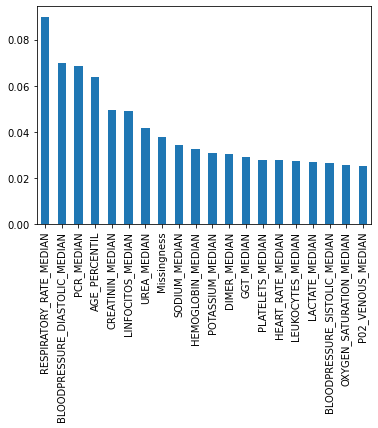

In [34]:
# Gini based feature importances
model_fin = RandomForestClassifier(random_state = 0, **rf_random.best_params_).fit(X_train, y_train)
feat_importances = pd.Series(model_fin.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='bar')


In [35]:
# 11: Evaluation
def ass(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy=(tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp)
    recall=tp/(tp+fn)

    #print("Recall:",recall*100)
    #print("Precision:",precision*100)
    #print("Accuracy:",accuracy*100)
    #print("F1 Score:", f1_score(y_true, y_pred)*100)
    #print("Precision-recall AUC:", auc(rf_recall, rf_precision))
    
    tab = [["Accuracy", accuracy*100], ["Recall", recall*100], ["Precision", precision*100], ["F1 Score", f1_score(y_true, y_pred)*100], ["Precision-recall AUC", auc(rf_recall, rf_precision)]]
    print(tabulate(tab, tablefmt="latex", headers = ['Evaluation Metric', 'Value']))
    
    
y_pred = model.predict(X_test)

# predict probabilities
rf_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)

ass(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
    

    

\begin{tabular}{lr}
\hline
 Evaluation Metric    &     Value \\
\hline
 Accuracy             & 74.5283   \\
 Recall               & 75.5102   \\
 Precision            & 71.1538   \\
 F1 Score             & 73.2673   \\
 Precision-recall AUC &  0.839844 \\
\hline
\end{tabular}
[[42 15]
 [12 37]]


Random Forest: f1=0.733 auc=0.840


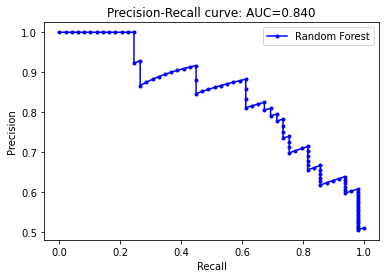

In [36]:
#PR AUC plot

rf_f1, rf_auc = f1_score(y_test, y_pred), auc(rf_recall, rf_precision)
# summarize scores
print('Random Forest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
# plot the precision-recall curves
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest', c = 'b')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# Title
plt.title('Precision-Recall curve: ''AUC={0:0.3f}'.format(auc(rf_recall, rf_precision)), loc='center')
# show the legend
plt.legend()
# show the plot
plt.show()


In [37]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        57
           1       0.71      0.76      0.73        49

    accuracy                           0.75       106
   macro avg       0.74      0.75      0.74       106
weighted avg       0.75      0.75      0.75       106



### SHAP
- Summary plot

In [38]:
# 12: SHAP 
import shap
final_model_pre = RandomForestClassifier(**rf_random.best_params_)
final_model = final_model_pre.fit(X_train, y_train)
check_additivity=False
explainer   = shap.TreeExplainer(model_fin)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [39]:
shap_values = explainer.shap_values(X_train, check_additivity=False)

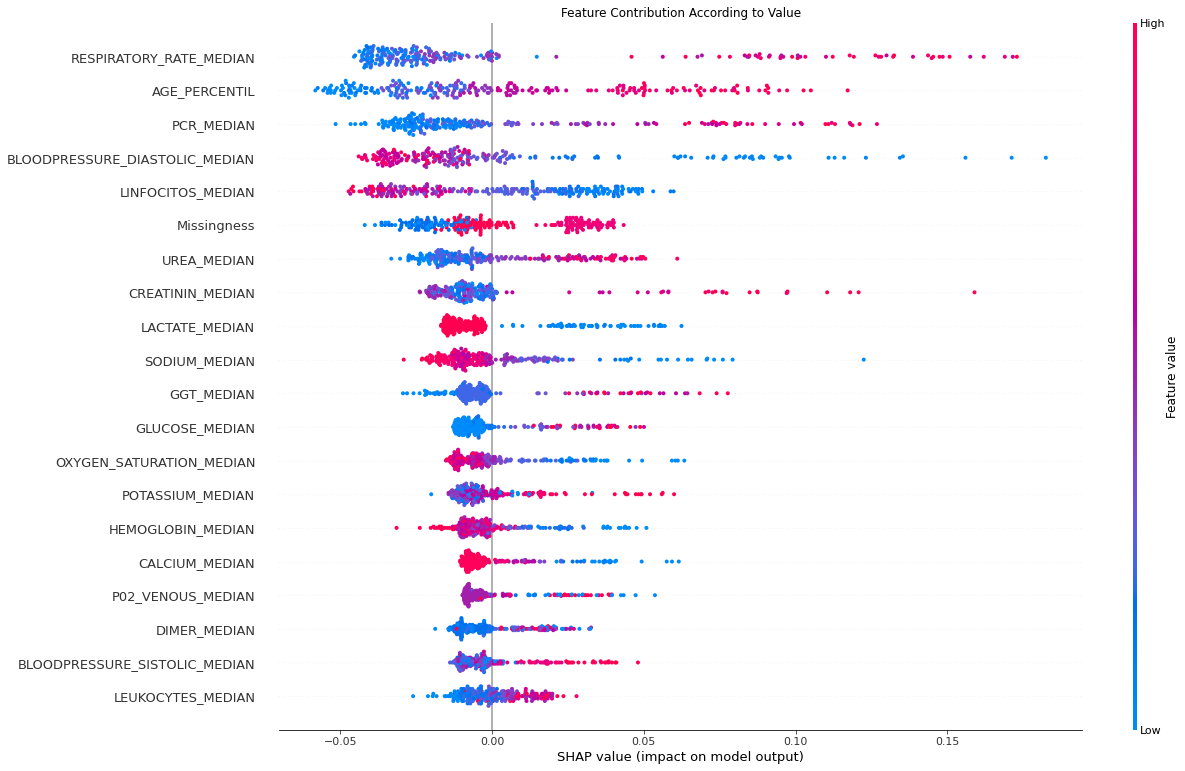

In [40]:
# Granular feature contribution plot
plt.title('Feature Contribution According to Value')
shap.summary_plot(shap_values[1], X_train, plot_size = (18,13))

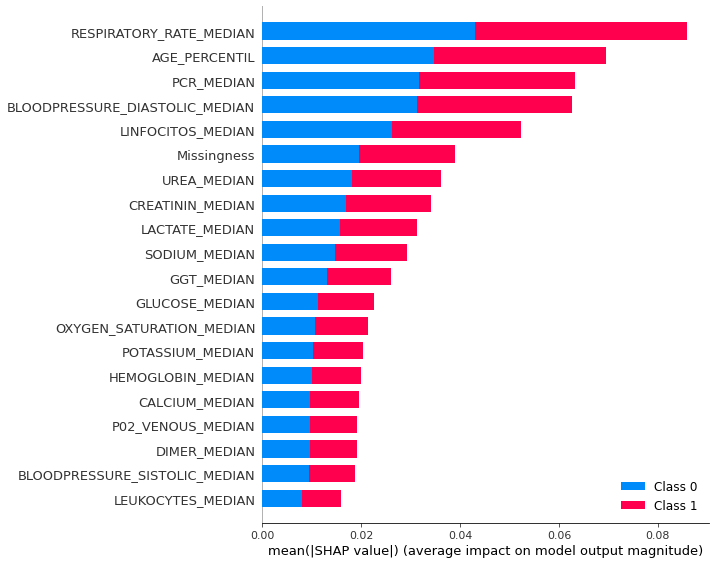

In [43]:
#This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
pip install tableone

In [45]:
from tableone import TableOne
mytablecols = comorb_lst + ['GENDER']+ ['AGE_PERCENTIL']
#mytable2cols = list(final_data[[col for col in final_data.columns if col not in mytablecols]].columns)
print(mytablecols)
#print(mytable2cols)

['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER', 'GENDER', 'AGE_PERCENTIL']


In [46]:
mytable = TableOne(final_data, columns = mytablecols , categorical = comorb_lst + ['GENDER'],  groupby = ['ICU'], decimals={"AGE_PERCENTIL": 0})
#mytable2 = TableOne(final_data, columns = mytable2cols,  groupby = ['ICU'])
                                             

In [47]:
print(mytable)

                              Grouped by ICU                                    
                                     Missing     Overall           0           1
n                                                    353         190         163
DISEASE GROUPING 1, n (%) 0.0              0  316 (89.5)  174 (91.6)  142 (87.1)
                          1.0                  37 (10.5)    16 (8.4)   21 (12.9)
DISEASE GROUPING 2, n (%) 0.0              0  345 (97.7)  188 (98.9)  157 (96.3)
                          1.0                    8 (2.3)     2 (1.1)     6 (3.7)
DISEASE GROUPING 3, n (%) 0.0              0  321 (90.9)  179 (94.2)  142 (87.1)
                          1.0                   32 (9.1)    11 (5.8)   21 (12.9)
DISEASE GROUPING 4, n (%) 0.0              0  346 (98.0)  189 (99.5)  157 (96.3)
                          1.0                    7 (2.0)     1 (0.5)     6 (3.7)
DISEASE GROUPING 5, n (%) 0.0              0  307 (87.0)  173 (91.1)  134 (82.2)
                          1.

In [48]:
#print(mytable2)

In [49]:
print(mytable.tabulate(tablefmt="latex"))

\begin{tabular}{llllll}
\hline
                           &     & Missing   & Overall    & 0          & 1          \\
\hline
 n                         &     &           & 353        & 190        & 163        \\
 DISEASE GROUPING 1, n (\%) & 0.0 & 0         & 316 (89.5) & 174 (91.6) & 142 (87.1) \\
                           & 1.0 &           & 37 (10.5)  & 16 (8.4)   & 21 (12.9)  \\
 DISEASE GROUPING 2, n (\%) & 0.0 & 0         & 345 (97.7) & 188 (98.9) & 157 (96.3) \\
                           & 1.0 &           & 8 (2.3)    & 2 (1.1)    & 6 (3.7)    \\
 DISEASE GROUPING 3, n (\%) & 0.0 & 0         & 321 (90.9) & 179 (94.2) & 142 (87.1) \\
                           & 1.0 &           & 32 (9.1)   & 11 (5.8)   & 21 (12.9)  \\
 DISEASE GROUPING 4, n (\%) & 0.0 & 0         & 346 (98.0) & 189 (99.5) & 157 (96.3) \\
                           & 1.0 &           & 7 (2.0)    & 1 (0.5)    & 6 (3.7)    \\
 DISEASE GROUPING 5, n (\%) & 0.0 & 0         & 307 (87.0) & 173 (91.1) & 134 (82.2) \\


In [50]:
#print(mytable2.tabulate(tablefmt="latex"))

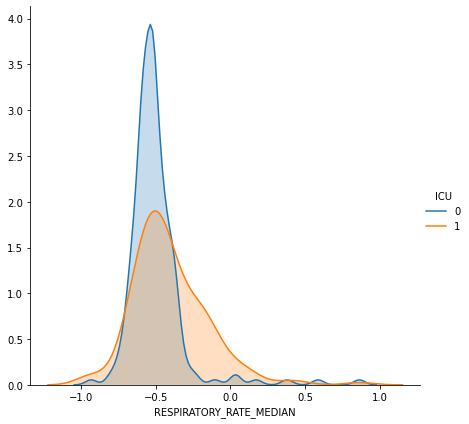

In [51]:
#RESPIRATORY_RATE_MEDIAN
g = sns.FacetGrid(final_data, hue="ICU", height=6)
g.map(sns.kdeplot, "RESPIRATORY_RATE_MEDIAN", shade=True,)
g.add_legend()

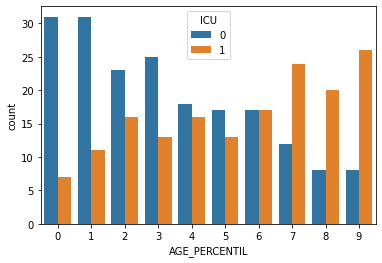

In [67]:
# Check age percentile balance
sns.countplot(x="AGE_PERCENTIL", hue="ICU", data=final_data)

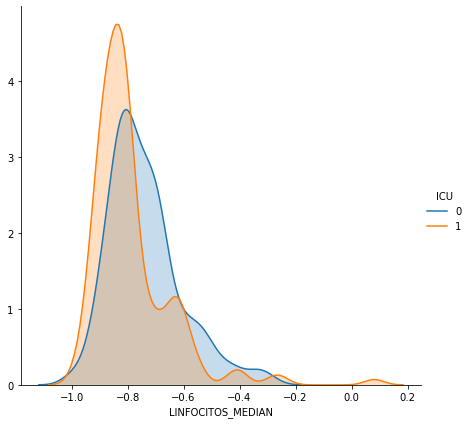

In [65]:
#LINFOCITOS_MEDIAN
g = sns.FacetGrid(final_data, hue="ICU", height=6)
g.map(sns.kdeplot, "LINFOCITOS_MEDIAN", shade=True,)
g.add_legend()

In [64]:
#Missingness
#g = sns.FacetGrid(final_data, hue="ICU", height=6)
#g.map(sns.kdeplot, "Missingness", shade=True,)
#g.add_legend()

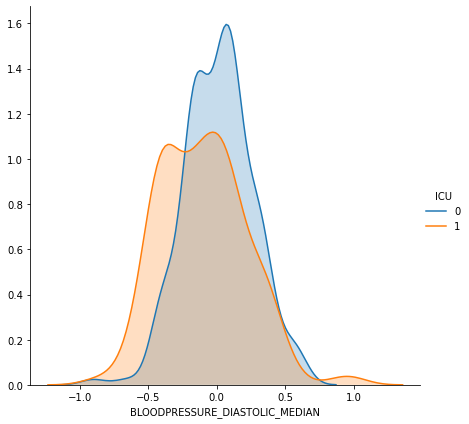

In [63]:
#BLOODPRESSURE_DIASTOLIC_MEDIAN
g = sns.FacetGrid(final_data, hue="ICU", height=6)
g.map(sns.kdeplot, "BLOODPRESSURE_DIASTOLIC_MEDIAN", shade=True,)
g.add_legend()

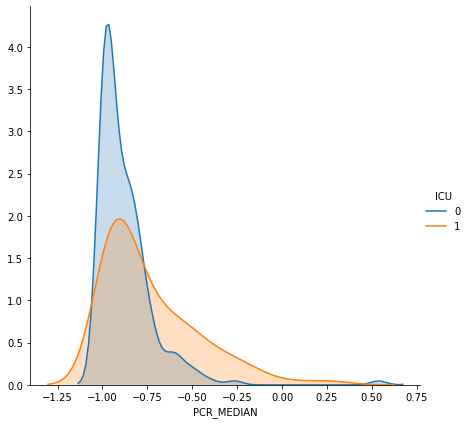

In [62]:
#PCR_MEDIAN
g = sns.FacetGrid(final_data, hue="ICU", height=6)
g.map(sns.kdeplot, "PCR_MEDIAN", shade=True,)
g.add_legend()

In [61]:
#UREA_MEDIAN
#g = sns.FacetGrid(final_data, hue="ICU", height=6)
#g.map(sns.kdeplot, "UREA_MEDIAN", shade=True,)
#g.add_legend()

In [60]:
#CREATININ_MEDIAN
#g = sns.FacetGrid(final_data, hue="ICU", height=6)
#g.map(sns.kdeplot, "CREATININ_MEDIAN", shade=True,)
#g.add_legend()